In [2]:
from pathlib import Path

In [3]:
from dataclasses import dataclass

In [4]:
import os

os.getcwd()
os.chdir("C:\\Users\somit\Downloads\project_ineuron\insurence_premium_prediction")
os.getcwd()

'C:\\Users\\somit\\Downloads\\project_ineuron\\insurence_premium_prediction'

In [5]:
from insurence_premium.constant import *
from insurence_premium.util.common import read_yaml ,create_directories
from pathlib import Path

In [6]:
@dataclass(frozen=True)
class DataIngestionConfig:
    root_dir: Path
    raw_data: Path
    ingested_train_dir: Path
    ingested_test_dir: Path


In [7]:
class ConfigurationManager:
    def __init__(
        self ,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config =read_yaml(config_filepath)
        self.params =read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])
    
    def get_data_ingestion_config(self)->DataIngestionConfig:
        ingestion_config =self.config.data_ingestion
        data_ingestion_config = DataIngestionConfig(
            root_dir=Path(ingestion_config.root_dir),
            raw_data=Path(ingestion_config.raw_data),
            ingested_train_dir=Path(ingestion_config.ingested_train_dir),
            ingested_test_dir =Path(ingestion_config.ingested_test_dir)
        )
        return data_ingestion_config

        

In [8]:
con_obj=ConfigurationManager()
con_obj.get_data_ingestion_config()

DataIngestionConfig(root_dir=WindowsPath('artifacts/data_ingestion'), raw_data=WindowsPath('artifacts/data_ingestion/raw_data/insurence.csv'), ingested_train_dir=WindowsPath('data_ingestion/train/insurence.csv'), ingested_test_dir=WindowsPath('data_ingestion/test/insurence.csv'))

In [9]:
import os

class DataIngestion:
    def __init__(self , config:DataIngestionConfig):
        self.config =config

    def download_data(self):
        try:
            raw_data = self.config.raw_data
            raw_data_dir ,file_name=os.path.split(raw_data)

            os.makedirs(raw_data_dir , exist_ok = True)
            
            raw_data_file_path =os.path.join(
                raw_data_dir , file_name
            ) 
            db_file_path = DB_FILE_PATH

            df=CassandraDatabaseManager(db_file_path=db_file_path).data_finder()
            df.to_csv(raw_data_file_path) 
            return raw_data_file_path

        except Exception as e:
            raise e

    def clean_data(self):
        try:
            pass
        except Exception as e:
            raise PremiException(e,sys) from e
            

In [10]:
from insurence_premium.cassandra_db.cassandra_db import CassandraDatabaseManager

In [11]:
try:
    con_obj=ConfigurationManager()
    data_ingestion_config=con_obj.get_data_ingestion_config()
    data =DataIngestion(config=data_ingestion_config)
    data.download_data()
except Exception as e:
    raise e    

In [12]:
import pandas as pd
df=pd.read_csv("C:\\Users\\somit\\Downloads\\project_ineuron\\insurence_premium_prediction\\artifacts\\data_ingestion\\raw_data\\insurence.csv")

In [13]:
df.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,expenses
0,0,28,female,25.9,1,no,northwest,4133.64
1,1,24,female,20.5,0,yes,northeast,14571.89
2,2,61,male,36.1,3,no,southwest,27941.29
3,3,21,male,31.1,0,no,southwest,1526.31
4,4,33,female,33.5,0,yes,southwest,37079.37


In [14]:
df['region'].unique()

array(['northwest', 'northeast', 'southwest', 'southeast'], dtype=object)

In [15]:
import matplotlib.pyplot as plt

In [16]:
for i in df['region'].unique():
    df_=df[df['region']==i]
    print(f"this is for: {i} region")
    print(df_['sex'].value_counts())
    print("-------------------------------------")


this is for: northwest region
female    164
male      160
Name: sex, dtype: int64
-------------------------------------
this is for: northeast region
male      163
female    161
Name: sex, dtype: int64
-------------------------------------
this is for: southwest region
male      163
female    162
Name: sex, dtype: int64
-------------------------------------
this is for: southeast region
male      189
female    175
Name: sex, dtype: int64
-------------------------------------


In [109]:
x=df.iloc[: ,:-1]
y =df['expenses']

In [110]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.get_n_splits(x, y)
import numpy as np

In [33]:
df["region"].unique()

array(['northwest', 'northeast', 'southwest', 'southeast'], dtype=object)

In [68]:
df['region'].unique()

array(['northwest', 'northeast', 'southwest', 'southeast'], dtype=object)

In [78]:
df=df.drop(columns="region_cat" ,axis=1)
    

In [79]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

In [83]:
df['region_cat']=df['region_cat'] +1

In [84]:
df['region_cat'].head()

0    2
1    1
2    4
3    4
4    4
Name: region_cat, dtype: int32

In [81]:
df['region_cat'] =label_encoder.fit_transform(df['region'])
df['region_cat'].head()

0    1
1    0
2    3
3    3
4    3
Name: region_cat, dtype: int32

In [94]:
df["region_label"] = pd.cut(
df["region_cat"],
bins=[0,1,2,3,4],
labels=[1,2,3,4]
)

In [99]:
df.head(2)

,Unnamed: 0,age,sex,bmi,children,smoker,region,expenses,region_cat,region_label
0,0,28,female,25.9,1,no,northwest,4133.64,2,2
1,1,24,female,20.5,0,yes,northeast,14571.89,1,1


In [108]:
y=np.array(y)
y

array([[ 4133.64, 14571.89, 27941.29, ...,  7624.63,  5488.26, 34439.86]])

In [111]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index,test_index in split.split(x, y):
    
    strat_train_set = df.loc[train_index].drop(["region_cat" ,"region_label"],axis=1)
    strat_test_set = df.loc[test_index].drop(["region_cat" ,"region_label"],axis=1)

In [112]:
strat_train_set.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,expenses
1215,1215,55,male,38.3,0,no,southeast,10226.28
547,547,43,female,32.6,3,yes,southeast,40941.29
370,370,43,male,30.1,3,no,northwest,8410.05
525,525,46,female,35.5,0,yes,northeast,42111.66
1093,1093,51,male,33.3,3,no,southeast,10560.49


In [114]:
strat_test_set.region.value_counts()

southeast    73
northwest    65
northeast    65
southwest    65
Name: region, dtype: int64

<AxesSubplot:xlabel='region_cat', ylabel='age'>

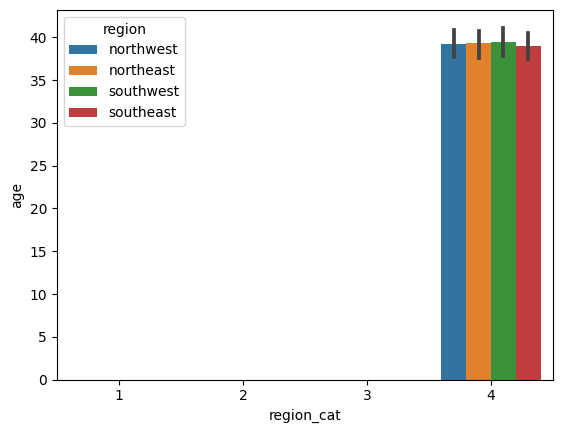

In [53]:
import seaborn as sns
df["age"].value_counts()
sns.barplot(x=df['region_cat'],y=df['age'] ,hue=df['region'])

In [ ]:
for train_index,test_index in split.split(housing_data_frame, housing_data_frame["income_cat"]):
    
    strat_train_set = housing_data_frame.loc[train_index].drop(["income_cat"],axis=1)
    strat_test_set = housing_data_frame.loc[test_index].drop(["income_cat"],axis=1)

In [2]:
from insurence_premium.entity.config_entity import DataIngestionConfig